In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn

import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [6]:
convai_train_dataset =rrnn.DatasetMultiTaskRRNN(convai_train_token,tasks,eval=False)

In [7]:
convai_val_dataset = rrnn.DatasetMultiTaskRRNN(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset  = rrnn.DatasetMultiTaskRRNN(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =  DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_multi)
dl_val = DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_multi)
dl_eval  = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_multi)

# Pruebas hiperparámetros 1

In [11]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

In [12]:
num_epochs = 100
learning_rate = 5e-5

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0759968387955987 	 Validation loss: 2.080381914720697 	 
  1%|          | 574/57400 [00:05<06:31, 145.31it/s]
Epoch 2 	 Training loss: 2.0746627003473685 	 Validation loss: 2.0801034418203064 	 
  2%|▏         | 1148/57400 [00:10<08:25, 111.22it/s]
Epoch 3 	 Training loss: 2.072045480748087 	 Validation loss: 2.073893745066756 	 
  3%|▎         | 1722/57400 [00:16<08:28, 109.44it/s]
Epoch 4 	 Training loss: 2.0686204213298574 	 Validation loss: 2.070172592744989 	 
  4%|▍         | 2296/57400 [00:22<08:36, 106.60it/s]
Epoch 5 	 Training loss: 2.067140631144055 	 Validation loss: 2.0697196903875317 	 
  5%|▌         | 2870/57400 [00:28<08:14, 110.27it/s]
Epoch 6 	 Training loss: 2.064863943472141 	 Validation loss: 2.0695198996592374 	 
  6%|▌         | 3444/57400 [00:33<06:28, 138.87it/s]
Epoch 7 	 Training loss: 2.0626193584050037 	 Validation loss: 2.069767289242502 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:37<06:21, 139.77it/s]
Epoch 

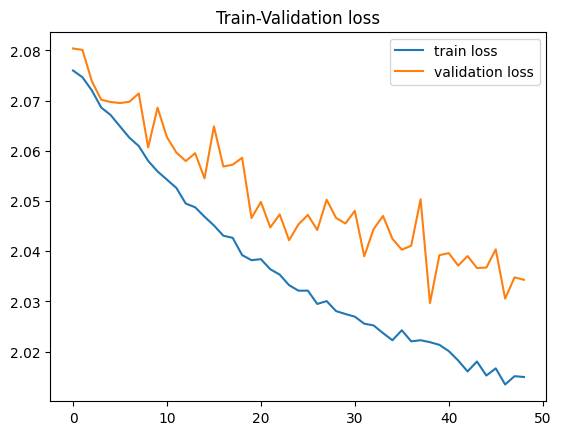

In [13]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_v1_1'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [14]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5277777777777778, 'precision': 0.5277777777777778, 'f1': 0.5277777777777778, 'accuracy': 0.5277777777777778}, 'as': {'recall': 0.5488917861799217, 'precision': 0.5488917861799217, 'f1': 0.5488917861799217, 'accuracy': 0.5488917861799217}, 'about': {'recall': 0.6262755102040817, 'precision': 0.6262755102040817, 'f1': 0.6262755102040817, 'accuracy': 0.6262755102040817}} 

Evaluación en etiquetas male
{'to': {'recall': 0.8223844282238443, 'precision': 0.8223844282238443, 'f1': 0.8223844282238444, 'accuracy': 0.8223844282238443}, 'as': {'recall': 0.8409090909090909, 'precision': 0.8409090909090909, 'f1': 0.8409090909090909, 'accuracy': 0.8409090909090909}, 'about': {'recall': 0.9010416666666666, 'precision': 0.9010416666666666, 'f1': 0.9010416666666666, 'accuracy': 0.9010416666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.2099737532808399, 'precision': 0.2099737532808399, 'f1': 0.2099737532808399, 'accuracy': 0.2099737532808399}, 'a

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.075549179668626 	 Validation loss: 2.0805833582150735 	 
  1%|          | 574/57400 [00:04<06:27, 146.63it/s]
Epoch 2 	 Training loss: 2.0744787745359465 	 Validation loss: 2.0778125140626553 	 
  2%|▏         | 1148/57400 [00:08<06:24, 146.44it/s]
Epoch 3 	 Training loss: 2.0728729988224415 	 Validation loss: 2.0792539968328962 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:12<06:27, 143.69it/s]
Epoch 4 	 Training loss: 2.070576671523915 	 Validation loss: 2.074012138075748 	 
  4%|▍         | 2296/57400 [00:17<06:19, 145.39it/s]
Epoch 5 	 Training loss: 2.06817802776443 	 Validation loss: 2.073557833493766 	 
  5%|▌         | 2870/57400 [00:21<06:11, 146.74it/s]
Epoch 6 	 Training loss: 2.0666099624766705 	 Validation loss: 2.0682245351500432 	 
  6%|▌         | 3444/57400 [00:25<06:11, 145.34it/s]
Epoch 7 	 Training loss: 2.0646966388416623 	 Validation loss: 2.0697858656867076 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [0

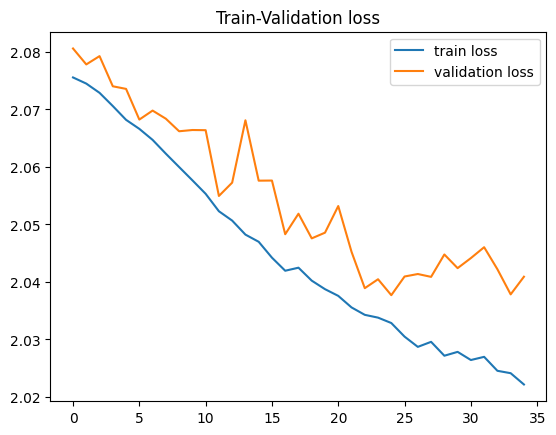

In [15]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_v1_2'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [16]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5037878787878788, 'precision': 0.5037878787878788, 'f1': 0.5037878787878788, 'accuracy': 0.5037878787878788}, 'as': {'recall': 0.5449804432855281, 'precision': 0.5449804432855281, 'f1': 0.5449804432855281, 'accuracy': 0.5449804432855281}, 'about': {'recall': 0.6301020408163265, 'precision': 0.6301020408163265, 'f1': 0.6301020408163265, 'accuracy': 0.6301020408163265}} 

Evaluación en etiquetas male
{'to': {'recall': 0.31630170316301703, 'precision': 0.31630170316301703, 'f1': 0.31630170316301703, 'accuracy': 0.31630170316301703}, 'as': {'recall': 0.34595959595959597, 'precision': 0.34595959595959597, 'f1': 0.34595959595959597, 'accuracy': 0.34595959595959597}, 'about': {'recall': 0.4557291666666667, 'precision': 0.4557291666666667, 'f1': 0.45572916666666663, 'accuracy': 0.4557291666666667}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7060367454068242, 'precision': 0.7060367454068242, 'f1': 0.7060367454068242, 'accuracy': 0.706036745406

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.07582691031466 	 Validation loss: 2.0797780408697615 	 
  1%|          | 574/57400 [00:04<06:37, 142.79it/s]
Epoch 2 	 Training loss: 2.0744901509235127 	 Validation loss: 2.081011275113639 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:08<06:25, 145.86it/s]
Epoch 3 	 Training loss: 2.071900797637913 	 Validation loss: 2.0767485570099393 	 
  3%|▎         | 1722/57400 [00:12<06:24, 144.76it/s]
Epoch 4 	 Training loss: 2.0682736223998384 	 Validation loss: 2.074329958123676 	 
  4%|▍         | 2296/57400 [00:17<06:18, 145.44it/s]
Epoch 5 	 Training loss: 2.0666963219227275 	 Validation loss: 2.074351953247846 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:21<06:15, 145.40it/s]
Epoch 6 	 Training loss: 2.06525046983247 	 Validation loss: 2.0733208939180536 	 
  6%|▌         | 3444/57400 [00:25<06:12, 144.86it/s]
Epoch 7 	 Training loss: 2.063045874705298 	 Validation loss: 2.0718942739195745 	 
  7%|▋         | 4018/57400 [00:3

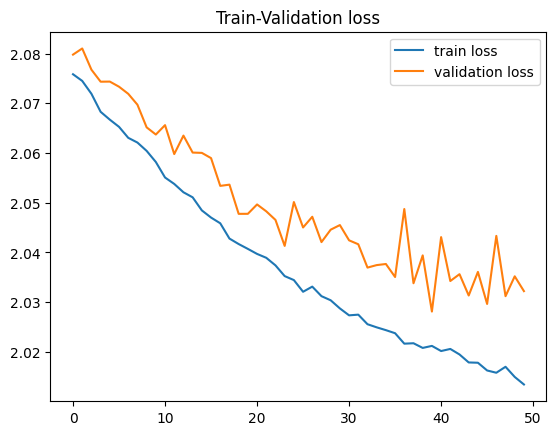

In [17]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_v1_3'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [18]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5202020202020202, 'precision': 0.5202020202020202, 'f1': 0.5202020202020202, 'accuracy': 0.5202020202020202}, 'as': {'recall': 0.5397653194263363, 'precision': 0.5397653194263363, 'f1': 0.5397653194263363, 'accuracy': 0.5397653194263363}, 'about': {'recall': 0.6020408163265306, 'precision': 0.6020408163265306, 'f1': 0.6020408163265306, 'accuracy': 0.6020408163265306}} 

Evaluación en etiquetas male
{'to': {'recall': 0.8321167883211679, 'precision': 0.8321167883211679, 'f1': 0.8321167883211679, 'accuracy': 0.8321167883211679}, 'as': {'recall': 0.8636363636363636, 'precision': 0.8636363636363636, 'f1': 0.8636363636363636, 'accuracy': 0.8636363636363636}, 'about': {'recall': 0.90625, 'precision': 0.90625, 'f1': 0.90625, 'accuracy': 0.90625}} 

Evaluación en etiquetas female
{'to': {'recall': 0.1837270341207349, 'precision': 0.1837270341207349, 'f1': 0.1837270341207349, 'accuracy': 0.1837270341207349}, 'as': {'recall': 0.1940700808625337, 'precisio

In [19]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6194727891156463, 'precision': 0.6194727891156463, 'f1': 0.6194727891156463, 'accuracy': 0.6194727891156463}
Métricas etiqueta male: {'recall': 0.7543402777777778, 'precision': 0.7543402777777778, 'f1': 0.7543402777777778, 'accuracy': 0.7543402777777778}
Métricas etiqueta female:  {'recall': 0.49, 'precision': 0.49, 'f1': 0.49, 'accuracy': 0.49}

 to
Resultado global: {'recall': 0.5172558922558923, 'precision': 0.5172558922558923, 'f1': 0.5172558922558923, 'accuracy': 0.5172558922558923}
Métricas etiqueta male: {'recall': 0.656934306569343, 'precision': 0.656934306569343, 'f1': 0.6569343065693432, 'accuracy': 0.656934306569343}
Métricas etiqueta female:  {'recall': 0.3665791776027997, 'precision': 0.3665791776027997, 'f1': 0.3665791776027997, 'accuracy': 0.3665791776027997}

 as
Resultado global: {'recall': 0.5445458496305954, 'precision': 0.5445458496305954, 'f1': 0.5445458496305954, 'accuracy': 0.5445458496305954}
Métricas e